In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io

from itertools import chain
from random import sample
import scipy
import cv2

In [3]:
pwd

'/home/ec2-user/SageMaker'

In [4]:
all_img_data = pd.read_csv('./data_labels_mainData.csv')
all_img_data.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
5,22410,1,22410.png,fibroblast,0,0
6,22411,1,22411.png,fibroblast,0,0
7,22412,1,22412.png,fibroblast,0,0
8,22413,1,22413.png,fibroblast,0,0
9,22414,1,22414.png,fibroblast,0,0


In [5]:
all_img_data.sample(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
3052,8312,18,8312.png,inflammatory,1,0
4484,16583,24,16583.png,inflammatory,1,0
719,9020,7,9020.png,fibroblast,0,0
1791,13538,10,13538.png,epithelial,2,1
3014,8948,17,8948.png,epithelial,2,1
1644,13382,10,13382.png,fibroblast,0,0
4532,16632,24,16632.png,others,3,0
4432,20271,23,20271.png,fibroblast,0,0
6476,8248,40,8248.png,epithelial,2,1
6142,10184,38,10184.png,fibroblast,0,0


In [6]:
all_img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


There is No *Missing values* in the dataset

In [7]:
all_img_data.shape

(9896, 6)

In [8]:
all_img_data.describe(include=['object','int64'])

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
count,9896.000000,9896.000000,9896,9896,9896.000000,9896.000000
unique,NaN,NaN,9896,4,NaN,NaN
top,NaN,NaN,1357.png,epithelial,NaN,NaN
freq,NaN,NaN,1,4079,NaN,NaN
mean,10193.880154,29.762025,NaN,NaN,1.501516,0.412187
std,6652.912660,17.486553,NaN,NaN,0.954867,0.492253
min,1.000000,1.000000,NaN,NaN,0.000000,0.000000
25%,4135.750000,14.000000,NaN,NaN,1.000000,0.000000
50%,9279.500000,26.000000,NaN,NaN,2.000000,0.000000
75%,16821.250000,47.000000,NaN,NaN,2.000000,1.000000


In [9]:
all_img_data['cellTypeName'].unique()

array(['fibroblast', 'inflammatory', 'others', 'epithelial'], dtype=object)

<AxesSubplot:>

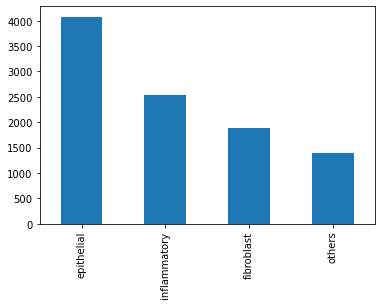

In [10]:
all_img_data['cellTypeName'].value_counts().plot(kind='bar')

<AxesSubplot:>

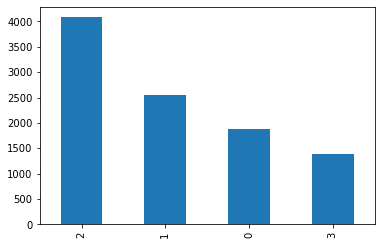

In [11]:
all_img_data['cellType'].value_counts().plot(kind='bar')

<AxesSubplot:>

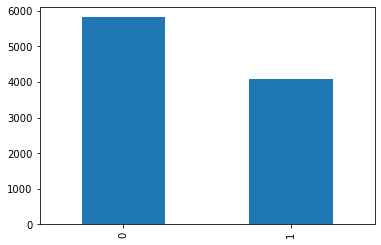

In [12]:
all_img_data['isCancerous'].value_counts().plot(kind='bar')

<AxesSubplot:>

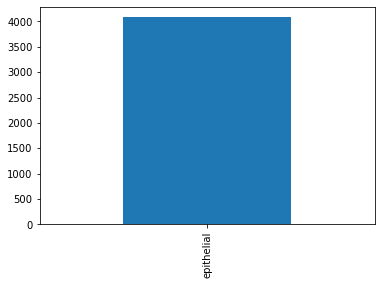

In [13]:
all_img_data[all_img_data['isCancerous'] == 1]['cellTypeName'].value_counts().plot(kind='bar')

<AxesSubplot:>

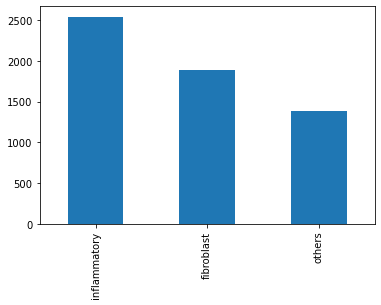

In [14]:
all_img_data[all_img_data['isCancerous'] == 0]['cellTypeName'].value_counts().plot(kind='bar')

<AxesSubplot:>

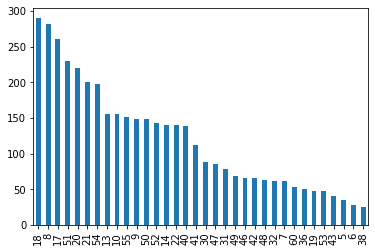

In [15]:
all_img_data[all_img_data['isCancerous'] == 1]['patientID'].value_counts().plot(kind='bar')

Patient number 18 have the most iscancoures images

In [16]:
all_cell_type = np.unique(list(chain(*all_img_data['cellTypeName'].map(lambda x: x.split()).tolist())))
all_cell_type = [x for x in all_cell_type if len(x)>0]
print('All types ({}): {}'.format(len(all_cell_type), all_cell_type))

All types (4): ['epithelial', 'fibroblast', 'inflammatory', 'others']


In [17]:
for c_label in all_cell_type:
    if len(c_label)>1:
        all_img_data[c_label] = all_img_data['cellTypeName'].map(lambda finding: 1.0 if c_label in finding else 0.0)
        
all_img_data.sample(10)
    

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
7089,18131,44,18131.png,inflammatory,1,0,0.0,0.0,1.0,0.0
1634,13371,10,13371.png,fibroblast,0,0,0.0,1.0,0.0,0.0
8952,14045,54,14045.png,epithelial,2,1,1.0,0.0,0.0,0.0
5100,16949,29,16949.png,inflammatory,1,0,0.0,0.0,1.0,0.0
4309,20138,23,20138.png,fibroblast,0,0,0.0,1.0,0.0,0.0
517,4121,6,4121.png,inflammatory,1,0,0.0,0.0,1.0,0.0
3751,577,20,577.png,epithelial,2,1,1.0,0.0,0.0,0.0
2194,4560,13,4560.png,epithelial,2,1,1.0,0.0,0.0,0.0
2334,3044,14,3044.png,inflammatory,1,0,0.0,0.0,1.0,0.0
5199,17059,29,17059.png,inflammatory,1,0,0.0,0.0,1.0,0.0


In [18]:
all_img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InstanceID    9896 non-null   int64  
 1   patientID     9896 non-null   int64  
 2   ImageName     9896 non-null   object 
 3   cellTypeName  9896 non-null   object 
 4   cellType      9896 non-null   int64  
 5   isCancerous   9896 non-null   int64  
 6   epithelial    9896 non-null   float64
 7   fibroblast    9896 non-null   float64
 8   inflammatory  9896 non-null   float64
 9   others        9896 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 773.2+ KB


In [19]:
subset_df = all_img_data.iloc[:,6:10].copy()
subset_df.head()

,epithelial,fibroblast,inflammatory,others
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [20]:
subset_df.drop('fibroblast',axis=1, inplace=True)
subset_df.drop('inflammatory', axis=1, inplace=True)
subset_df.drop('others', axis=1, inplace=True)
subset_df.head()

,epithelial
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [21]:
all_img_data['CancerousCount'] = subset_df.sum(axis=1)
all_img_data.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others,CancerousCount
0,22405,1,22405.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
1,22406,1,22406.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
2,22407,1,22407.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
3,22408,1,22408.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
4,22409,1,22409.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
5,22410,1,22410.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
6,22411,1,22411.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
7,22412,1,22412.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
8,22413,1,22413.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0
9,22414,1,22414.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0


In [22]:
all_img_data['CancerousCount'].value_counts()

0.0    5817
1.0    4079
Name: CancerousCount, dtype: int64

Text(0, 0.5, 'Patients Count')

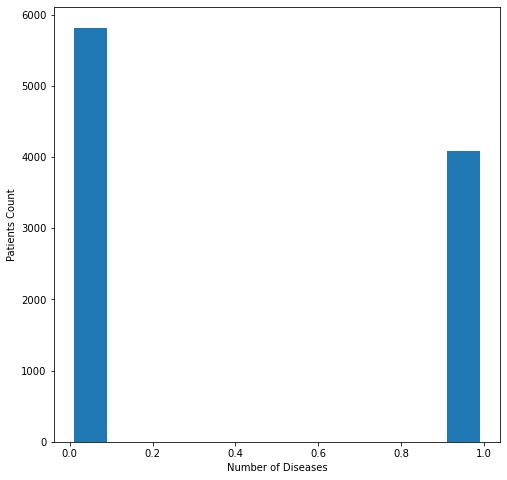

In [23]:


plt.figure(figsize=(8,8))
plt.hist(all_img_data['CancerousCount'], rwidth=0.8)
plt.xlabel('Number of Diseases')
plt.ylabel('Patients Count')



In [24]:
all_img_data.head(1)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others,CancerousCount
0,22405,1,22405.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0


In [25]:
def get_image_path(row):
    fpath = None
    f = row['ImageName']
    for d in range(9896):
        #dname = 'images_' + str(d).zfill(3)
        fname = './patch_images/' + f
        #if os.path.isfile(fname):
           # fpath = fname
           # break
    return fname

all_img_data['Image_path'] = all_img_data.apply(get_image_path, axis=1)
all_img_data.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others,CancerousCount,Image_path
0,22405,1,22405.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0,./patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0,./patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0,./patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0,./patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,0.0,1.0,0.0,0.0,0.0,./patch_images/22409.png


In [26]:
!ls /patch_images/

ls: cannot access /patch_images/: No such file or directory


In [27]:
epithelial_sample = all_img_data[all_img_data['epithelial'] == 1]
len(epithelial_sample)

4079

In [28]:
epi_example_1 = epithelial_sample.iloc[0]
epi_example_2 = epithelial_sample.iloc[1]
epi_example_3 = epithelial_sample.iloc[2]
epi_example_4 = epithelial_sample.iloc[3]
epi_example_5 = epithelial_sample.iloc[4]   

In [29]:
def show_image_distr(img_data):
    f = plt.figure()
    f.set_figwidth(10)

    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data,cmap='gray')


    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)

    plt.show()

In [30]:
ex1_data = image.imread('./patch_images/' + epi_example_1['ImageName'])
show_image_distr(ex1_data)

NameError: name 'image' is not defined

In [ ]:
ex2_data = image.imread('./patch_images/' + epi_example_2['ImageName'])
show_image_distr(ex2_data)

In [ ]:
ex3_data = image.imread('./patch_images/' + epi_example_3['ImageName'], cmap = 'CMRmap')
show_image_distr(ex3_data)

In [ ]:
ex4_data = image.imread('./patch_images/' + epi_example_4['ImageName'])
show_image_distr(ex4_data)

In [ ]:
ex5_data = image.imread('./patch_images/' + epi_example_5['ImageName'])
show_image_distr(ex5_data)

In [ ]:
uniqe_patients_num = all_img_data['patientID'].nunique()
print(f'Total unique number of patient: {uniqe_patients_num}, avg of records per patient: {len(all_img_data)/uniqe_patients_num :.2f}')

In [ ]:
record_per_patient = []
for pid in all_img_data['patientID'].unique():
    record_per_patient.append(len(all_img_data[all_img_data['patientID'] == pid]))

In [ ]:
plt.hist(record_per_patient, bins=max(record_per_patient))
plt.show()

In [ ]:
def num_records_per_patient(num):
    return(np.array(record_per_patient) == num*np.ones(len(record_per_patient))).sum()

In [ ]:
for i in range(1,20):
    print(f'Number of patients with {i} records in the dataset: {num_records_per_patient(i)}) \
    ({100.0*num_records_per_patient(i)/uniqe_patients_num :.2f})')    

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA as sklearnPCA